<a href="https://colab.research.google.com/github/ayyucedemirbas/multi_omics_BRCA_TCGA/blob/main/patient_node.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
class GraphNeuralLayer(layers.Layer):
    def __init__(self, units, activation='relu', use_bias=True, **kwargs):
        super(GraphNeuralLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias

    def build(self, input_shape):
        # input_shape: [(batch, nodes, features), (batch, nodes, nodes)]
        feature_dim = input_shape[0][-1]

        # Message passing weights
        self.W_msg = self.add_weight(
            name='W_msg',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # Self-connection weights
        self.W_self = self.add_weight(
            name='W_self',
            shape=(feature_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.units,),
                initializer='zeros',
                trainable=True
            )

        super(GraphNeuralLayer, self).build(input_shape)

    def call(self, inputs):
        features, adjacency = inputs

        # Self-connection: process own features
        self_output = tf.matmul(features, self.W_self)

        # Message passing: aggregate neighbor information
        neighbor_messages = tf.matmul(features, self.W_msg)
        aggregated = tf.matmul(adjacency, neighbor_messages)

        # Combine self and neighbor information
        output = self_output + aggregated

        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)

        return self.activation(output)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias
        }
        base_config = super(GraphNeuralLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
def load_and_preprocess_data():
    try:
        df = pd.read_csv('data.csv')
        print(f"Shape: {df.shape}")

        print(f"Missing values per column: {df.isnull().sum().sum()}")
        if df.isnull().sum().sum() > 0:
            # Fill missing values with median for numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
            print("Missing values filled with median")

        unique_values = df['vital.status'].unique()
        print(f"Unique vital.status values: {unique_values}")

        if set(unique_values).issubset({0, 1}):
            pass
        elif set(unique_values).issubset({'Alive', 'Dead', 'alive', 'dead'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'alive': 0, 'dead': 1})
        elif set(unique_values).issubset({'Living', 'Deceased', 'living', 'deceased'}):
            df['vital.status'] = df['vital.status'].str.lower().map({'living': 0, 'deceased': 1})
        else:
            le = LabelEncoder()
            df['vital.status'] = le.fit_transform(df['vital_status'])
            print(f"Label encoding applied: {dict(zip(le.classes_, le.transform(le.classes_)))}")

        # Check initial label distribution
        print("Initial label distribution:")
        label_counts = df["vital.status"].value_counts()
        print(label_counts)

        df_majority = df[df["vital.status"] == 0]
        df_minority = df[df["vital.status"] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,
                                         n_samples=len(df_majority),
                                         random_state=42)

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_majority, df_minority_upsampled])

        # Verify the new distribution
        print("After upsampling:")
        label_counts_upsampled = df_balanced["vital.status"].value_counts()
        print(label_counts_upsampled)

        # Separate feature types
        rna_cols = [col for col in df_balanced.columns if col.startswith('rs_')]
        cn_cols = [col for col in df_balanced.columns if col.startswith('cn_')]
        mu_cols = [col for col in df_balanced.columns if col.startswith('mu_')]
        pp_cols = [col for col in df_balanced.columns if col.startswith('pp_')]

        print(f"Feature distribution:")
        print(f"  RNA-seq (rs_): {len(rna_cols)}")
        print(f"  Copy Number (cn_): {len(cn_cols)}")
        print(f"  Mutation (mu_): {len(mu_cols)}")
        print(f"  Protein (pp_): {len(pp_cols)}")

        return df_balanced

    except FileNotFoundError:
        print("Error: data.csv file not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [4]:
df = load_and_preprocess_data()

Shape: (705, 1937)
Missing values per column: 0
Unique vital.status values: [0 1]
Initial label distribution:
vital.status
0    611
1     94
Name: count, dtype: int64
After upsampling:
vital.status
0    611
1    611
Name: count, dtype: int64
Feature distribution:
  RNA-seq (rs_): 604
  Copy Number (cn_): 860
  Mutation (mu_): 249
  Protein (pp_): 223


In [14]:
def create_patient_adjacency_matrix(X, method='cosine', threshold=0.7, k_neighbors=10):
    #Create adjacency matrix where nodes are patients (samples)
    n_patients = X.shape[0]
    print(f"Creating patient adjacency matrix for {n_patients} patients")

    if method == 'cosine':
        # Compute cosine similarity between patients
        from sklearn.metrics.pairwise import cosine_similarity
        similarity_matrix = cosine_similarity(X)
        # Convert to adjacency matrix
        adj_matrix = (similarity_matrix > threshold).astype(np.float32)

    elif method == 'correlation':
        # Compute correlation between patient feature vectors
        corr_matrix = np.corrcoef(X)
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
        adj_matrix = (np.abs(corr_matrix) > threshold).astype(np.float32)

    else:
        from sklearn.neighbors import kneighbors_graph
        adj_matrix = kneighbors_graph(X, n_neighbors=min(k_neighbors, n_patients//4),
                                    mode='connectivity', include_self=False)
        adj_matrix = adj_matrix.toarray().astype(np.float32)
        adj_matrix = (adj_matrix + adj_matrix.T) / 2  # Make symmetric

    # Remove self-loops initially, then add them back
    np.fill_diagonal(adj_matrix, 0)
    adj_matrix += np.eye(n_patients, dtype=np.float32)

    # Normalize adjacency matrix
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    degree_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(degree_matrix) + 1e-6))
    adj_normalized = degree_inv_sqrt @ adj_matrix @ degree_inv_sqrt

    print(f"Patient adjacency matrix shape: {adj_normalized.shape}")
    print(f"Number of patient connections: {np.sum(adj_matrix > 0) // 2}")

    return adj_normalized.astype(np.float32)

In [5]:
def visualize_data(df, adj_matrix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].pie(df['vital.status'].value_counts(),
                   labels=['Alive', 'Deceased'], autopct='%1.1f%%')
    axes[0, 0].set_title('Class Distribution')

    # Feature type distributions
    rna_cols = [col for col in df.columns if col.startswith('rs_')]
    cn_cols = [col for col in df.columns if col.startswith('cn_')]
    mu_cols = [col for col in df.columns if col.startswith('mu_')]
    pp_cols = [col for col in df.columns if col.startswith('pp_')]

    feature_counts = [len(rna_cols), len(cn_cols), len(mu_cols), len(pp_cols)]
    axes[0, 1].bar(['RNA-seq', 'Copy Number', 'Mutation', 'Protein'], feature_counts)
    axes[0, 1].set_title('Feature Types Distribution')
    axes[0, 1].set_ylabel('Number of Features')

    # Sample feature distributions by class
    if len(rna_cols) > 0:
        sample_features = df[rna_cols[:10]].values
        axes[0, 2].boxplot([sample_features[df['vital.status'] == 0].flatten(),
                            sample_features[df['vital.status'] == 1].flatten()],
                           labels=['Alive', 'Deceased'])
        axes[0, 2].set_title('Sample RNA-seq Features by Class')
        axes[0, 2].set_ylabel('Expression Level')
    else:
        axes[0, 2].text(0.5, 0.5, 'No RNA-seq features found', ha='center', va='center')

    # Patient adjacency matrix heatmap
    sample_adj = adj_matrix[:50, :50]  # Show subset for visibility
    sns.heatmap(sample_adj, cmap='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('Patient Adjacency Matrix (50x50 subset)')

    # Patient connectivity degree distribution
    degrees = np.sum(adj_matrix > 0, axis=1)
    axes[1, 1].hist(degrees, bins=30, alpha=0.7)
    axes[1, 1].set_title('Patient Connectivity Distribution')
    axes[1, 1].set_xlabel('Number of Connections')
    axes[1, 1].set_ylabel('Frequency')

    # PCA visualization
    features = df.drop('vital.status', axis=1).values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)

    colors = ['blue' if x == 0 else 'red' for x in df['vital.status']]
    axes[1, 2].scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.6)
    axes[1, 2].set_title(f'PCA Visualization\n(Explained variance: {pca.explained_variance_ratio_.sum():.3f})')
    axes[1, 2].set_xlabel('First Principal Component')
    axes[1, 2].set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

In [6]:
def build_patient_gnn_model(n_patients, n_features, num_classes=2):
    # Input: [batch_size=1, n_patients, n_features]
    feature_input = keras.Input(shape=(n_patients, n_features), name='patient_features')
    adjacency_input = keras.Input(shape=(n_patients, n_patients), name='patient_adjacency')

    # GNN layers for patient nodes
    x = GraphNeuralLayer(128, activation='relu')([feature_input, adjacency_input])
    x = layers.Dropout(0.3)(x)

    x = GraphNeuralLayer(64, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.3)(x)

    x = GraphNeuralLayer(32, activation='relu')([x, adjacency_input])
    x = layers.Dropout(0.2)(x)

    # Global pooling to get graph-level representation
    # Since we're predicting for individual patients, we'll extract node embeddings
    # For training, we'll use all patient nodes and their labels

    # Output layer: one prediction per patient node
    outputs = layers.Dense(1, activation='sigmoid', name='patient_predictions')(x)

    model = keras.Model(inputs=[feature_input, adjacency_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
def prepare_patient_graph_data(X_train, X_test, adj_matrix_full, train_indices, test_indices):
    n_patients_total = X_train.shape[0] + X_test.shape[0]
    n_features = X_train.shape[1]

    # Combine all patient features for the full graph
    X_all = np.vstack([X_train, X_test])

    # Reshape for graph input: [1, n_patients, n_features]
    X_graph = X_all.reshape(1, n_patients_total, n_features)

    # Adjacency matrix: [1, n_patients, n_patients]
    adj_batch = adj_matrix_full.reshape(1, n_patients_total, n_patients_total)

    return X_graph, adj_batch, train_indices, test_indices

In [8]:
def train_and_evaluate_patient_model(model, X_train, X_test, y_train, y_test, adj_matrix):
    # We need to work with the full graph structure
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    train_indices = np.arange(n_train)
    test_indices = np.arange(n_train, n_train + n_test)

    X_graph, adj_batch, train_idx, test_idx = prepare_patient_graph_data(
        X_train, X_test, adj_matrix, train_indices, test_indices
    )

    print(f"Graph input shape: {X_graph.shape}")
    print(f"Adjacency batch shape: {adj_batch.shape}")
    print(f"Train indices: {len(train_idx)}, Test indices: {len(test_idx)}")

    # For training, we need to create a custom training loop since we're working with a single graph containing all patients

    # Combine labels
    y_all = np.concatenate([y_train, y_test])

    # Create masks for training and testing
    train_mask = np.zeros(len(y_all), dtype=bool)
    test_mask = np.zeros(len(y_all), dtype=bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    # Custom training function for patient GNN
    def train_step(model, X_graph, adj_batch, y_all, train_mask):
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model([X_graph, adj_batch])  # Shape: [1, n_patients, 1]
            predictions = tf.squeeze(predictions, axis=[0, 2])  # Shape: [n_patients]

            # Only compute loss on training patients
            train_predictions = tf.boolean_mask(predictions, train_mask)
            train_labels = tf.boolean_mask(y_all, train_mask)

            loss = keras.losses.binary_crossentropy(train_labels, train_predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss, train_predictions, train_labels

    epochs = 100
    best_val_acc = 0
    patience = 15
    patience_counter = 0

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        loss, train_preds, train_labels = train_step(
            model, X_graph, adj_batch, y_all, train_mask
        )

        val_predictions = model([X_graph, adj_batch])
        val_predictions = tf.squeeze(val_predictions, axis=[0, 2])
        val_preds = tf.boolean_mask(val_predictions, test_mask)
        val_labels = tf.boolean_mask(y_all, test_mask)

        val_loss = tf.reduce_mean(keras.losses.binary_crossentropy(val_labels, val_preds))

        train_acc = tf.reduce_mean(tf.cast(
            tf.equal(tf.round(train_preds), train_labels), tf.float32
        ))
        val_acc = tf.reduce_mean(tf.cast(
            tf.equal(tf.round(val_preds), val_labels), tf.float32
        ))

        history['loss'].append(float(loss))
        history['val_loss'].append(float(val_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={loss:.4f}, Val_Loss={val_loss:.4f}, "
                  f"Acc={train_acc:.4f}, Val_Acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model.save_weights('best_patient_model.weights.h5')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    model.load_weights('best_patient_model.weights.h5')
    final_predictions = model([X_graph, adj_batch])
    final_predictions = tf.squeeze(final_predictions, axis=[0, 2])

    test_pred_proba = tf.boolean_mask(final_predictions, test_mask).numpy()
    test_pred = (test_pred_proba > 0.5).astype(int)

    print(f"\nFinal Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred))

    auc_score = roc_auc_score(y_test, test_pred_proba)
    print(f"AUC Score: {auc_score:.4f}")

    return model, history, test_pred_proba, test_pred

In [9]:
def plot_results(history, y_test, y_pred_proba, y_pred):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].plot(history['loss'], label='Training Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Alive', 'Deceased'],
                yticklabels=['Alive', 'Deceased'],
                ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    axes[1, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
X = df.drop(columns=["vital.status"]).values.astype(np.float32)
y = df["vital.status"].values.astype(np.float32)
feature_names = df.drop(columns=["vital.status"]).columns.tolist()

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
X_all = np.vstack([X_train, X_test])
adj_matrix = create_patient_adjacency_matrix(
    X_all, method='cosine', threshold=0.5, k_neighbors=10
)

Creating patient adjacency matrix for 1222 patients
Patient adjacency matrix shape: (1222, 1222)
Number of patient connections: 2982


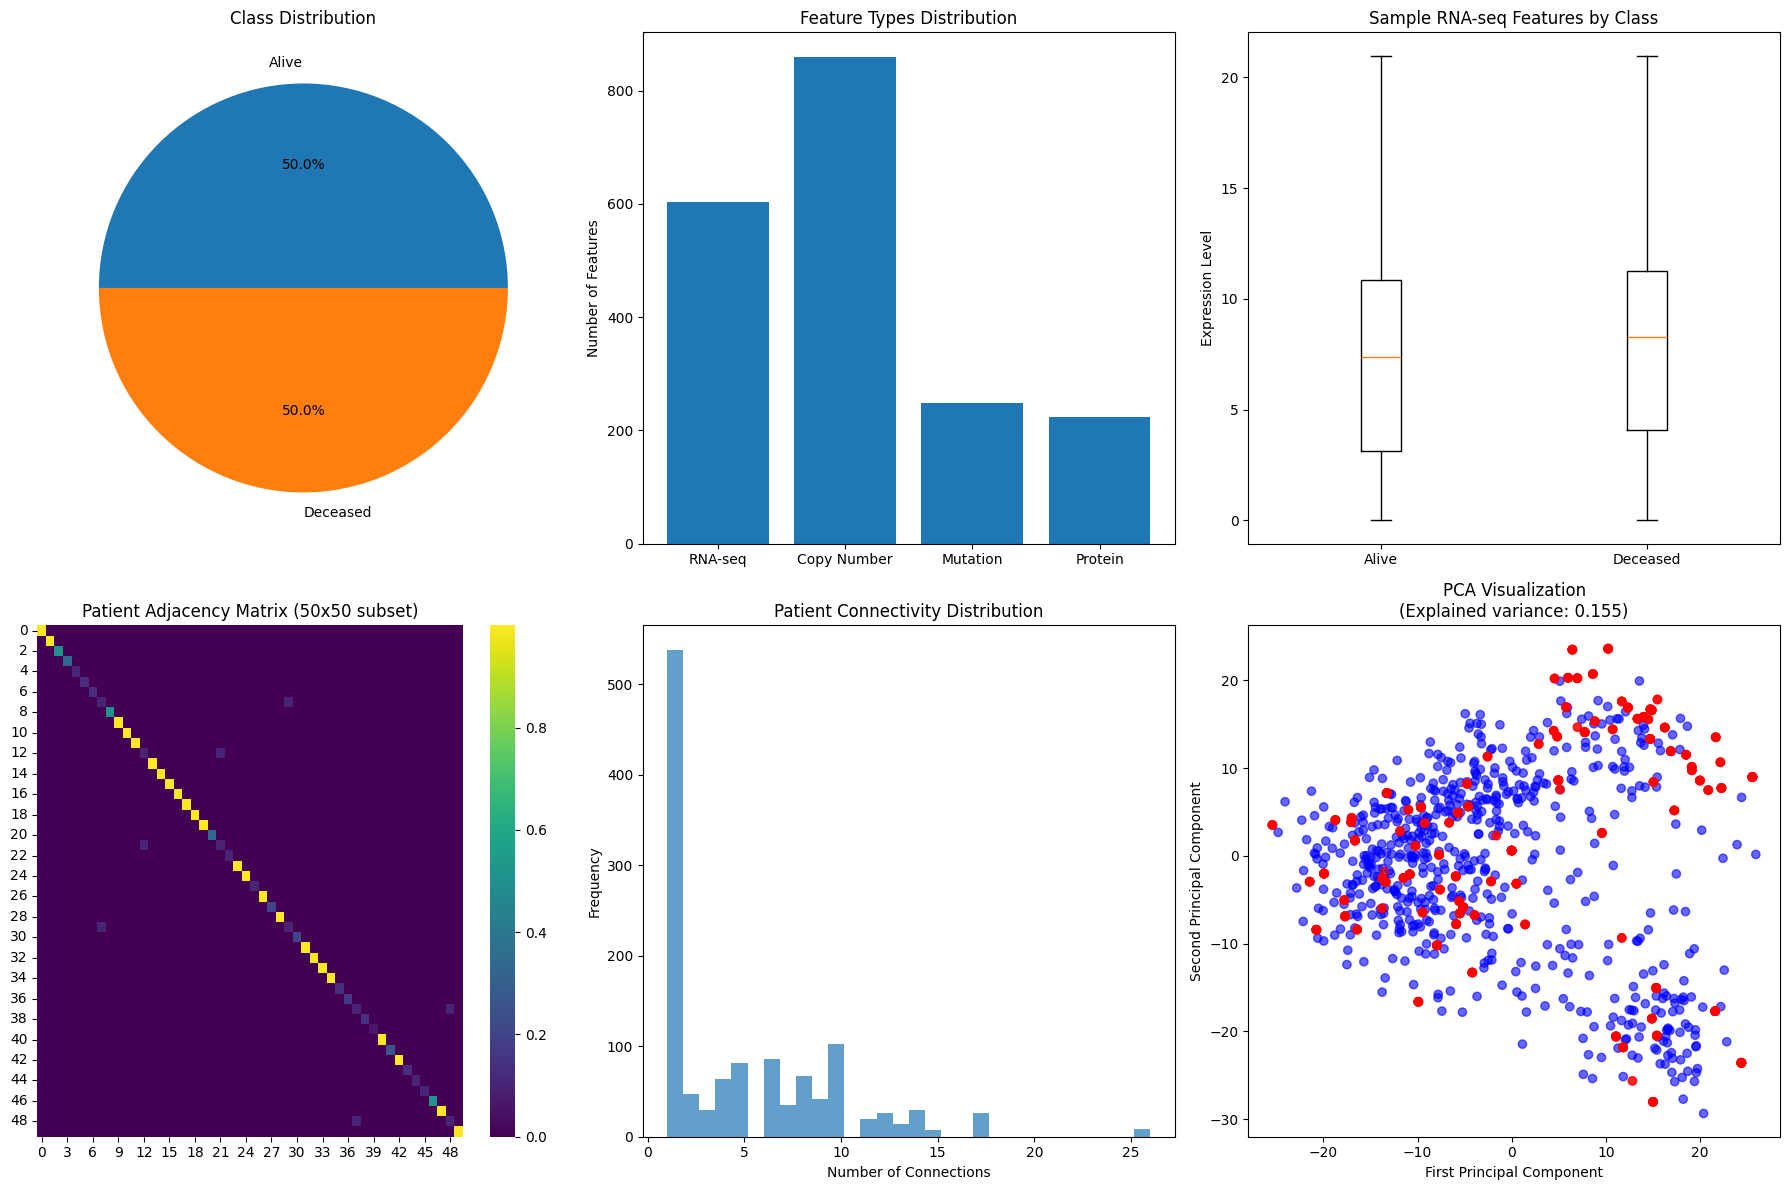

In [16]:
visualize_data(df, adj_matrix)

In [17]:
n_patients = X_all.shape[0]
n_features = X_all.shape[1]
model = build_patient_gnn_model(n_patients=n_patients, n_features=n_features)

In [18]:
n_patients

1222

In [19]:
n_features

1936

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ patient_features    │ (None, 1222,      │          0 │ -                 │
│ (InputLayer)        │ 1936)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patient_adjacency   │ (None, 1222,      │          0 │ -                 │
│ (InputLayer)        │ 1222)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer  │ (None, 1222, 128) │    495,744 │ patient_features… │
│ (GraphNeuralLayer)  │                   │            │ patient_adjacenc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1222, 128) │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 1222, 64)  │     16,448 │ dropout[0][0],    │
│ (GraphNeuralLayer)  │                   │            │ patient_adjacenc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1222, 64)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_neural_layer… │ (None, 1222, 32)  │      4,128 │ dropout_1[0][0],  │
│ (GraphNeuralLayer)  │                   │            │ patient_adjacenc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1222, 32)  │          0 │ graph_neural_lay… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patient_predictions │ (None, 1222, 1)   │         33 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 516,353 (1.97 MB)

 Trainable params: 516,353 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model, history, y_pred_proba, y_pred = train_and_evaluate_patient_model(
    model, X_train, X_test, y_train, y_test, adj_matrix
)

Graph input shape: (1, 1222, 1936)
Adjacency batch shape: (1, 1222, 1222)
Train indices: 977, Test indices: 245
Epoch 0: Loss=1.2865, Val_Loss=0.6663, Acc=0.4350, Val_Acc=0.7020
Epoch 10: Loss=0.0207, Val_Loss=0.0933, Acc=0.9980, Val_Acc=0.9755
Epoch 20: Loss=0.0040, Val_Loss=0.0649, Acc=1.0000, Val_Acc=0.9837
Early stopping at epoch 26

Final Test Accuracy: 0.9837

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       123
         1.0       0.97      1.00      0.98       122

    accuracy                           0.98       245
   macro avg       0.98      0.98      0.98       245
weighted avg       0.98      0.98      0.98       245

AUC Score: 0.9940


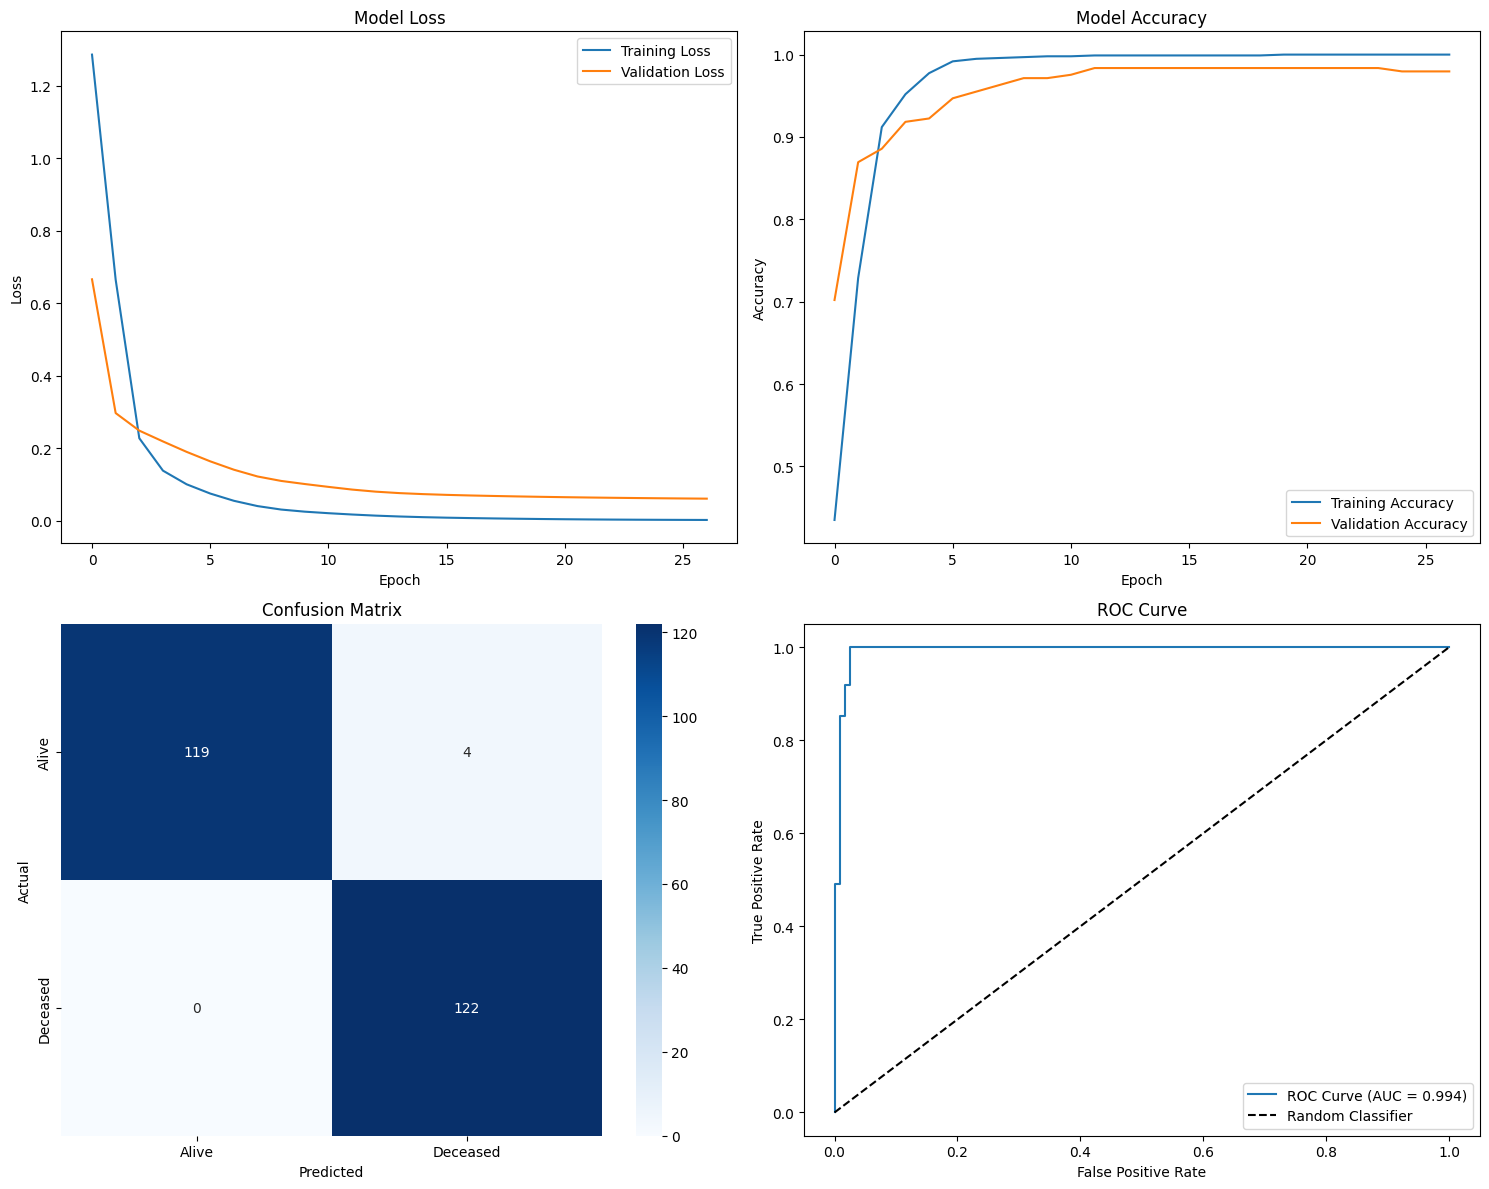

In [22]:
plot_results(history, y_test, y_pred_proba, y_pred)

In [23]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Accuracy: 0.9837
AUC Score: 0.9940


In [24]:
degrees = np.sum(adj_matrix > 0, axis=1)
print(f"\nPatient Graph Statistics:")
print(f"Average patient connections: {np.mean(degrees):.2f}")
print(f"Max patient connections: {np.max(degrees)}")
print(f"Min patient connections: {np.min(degrees)}")
print(f"Total edges in patient graph: {np.sum(adj_matrix > 0) // 2}")


Patient Graph Statistics:
Average patient connections: 4.88
Max patient connections: 26
Min patient connections: 1
Total edges in patient graph: 2982
